## Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

%matplotlib inline

## Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

## Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
with open(EXAMPLE_FILE, encoding = 'latin-1') as stream:
    message = stream.read()
    
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [6]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions

In [7]:
def generate_squares(N = 10):
    for number in range(N):
        yield number ** 2

In [8]:
for i in generate_squares(3):
    print(i, end=' ->')

0 ->1 ->4 ->

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirname, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding = 'latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = ''.join(lines)
            
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
nonspam_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
nonspam_emails = nonspam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
nonspam_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\nThursday...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n \nAlready the...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [14]:
nonspam_emails.shape

(3901, 2)

In [15]:
data = pd.concat([spam_emails, nonspam_emails])
print(data.shape)
data.head()

(5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,1


In [16]:
print(nonspam_emails.iloc[0,0])

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55

## Data Cleaning: Checking for Missing Values

In [17]:
#check if any message body is null
data['MESSAGE'].isnull().values.any()

False

In [18]:
# check if there are empty emails (string length zero)

(data.MESSAGE.str.len() == 0).sum()

3

In [19]:
# check the number of entries with null/None values
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [20]:
data[data.MESSAGE.str.len() == 0]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [21]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

### Remove system file entries from dataframe

In [22]:
data.drop(['cmds'], inplace = True)

### Add Document IDs to Track Emails in Dataset

In [23]:
document_ids = range(0, len(data))
document_ids

range(0, 5796)

In [24]:
data['DOC_ID'] = document_ids

In [25]:
data

,MESSAGE,CATEGORY,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,2
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,1,4
...,...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0,5792
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,5794


In [26]:
data['FILE_NAME'] = data.index
data.head()

,MESSAGE,CATEGORY,DOC_ID,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,1,4,00005.57696a39d7d84318ce497886896bf90d


In [27]:
data.set_index('DOC_ID', inplace = True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n1) Slim Down ...,1,00005.57696a39d7d84318ce497886896bf90d


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\nNow this is probably of no use to...",0,01400.f897f0931e461e7b2e964d28e927c35e


## Save to File using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visulised (Pie Charts)

In [30]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

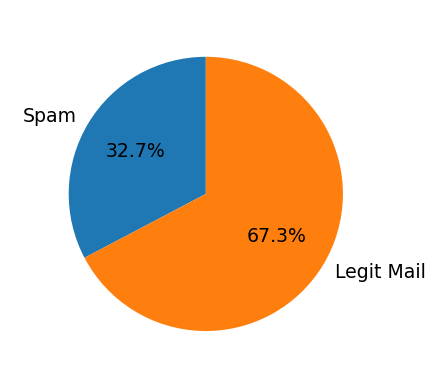

In [32]:
plt.figure(figsize = (2,2), dpi = 227)

plt.pie(sizes, labels = category_names, textprops = {'fontsize':6}, startangle=90, autopct='%1.1f%%')
plt.show()

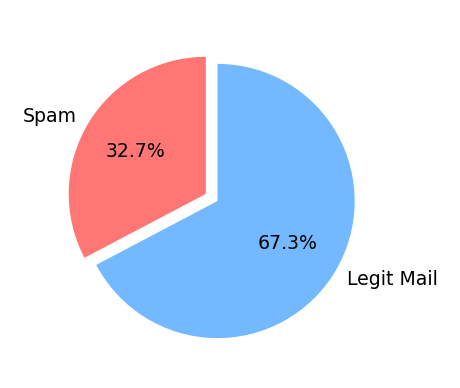

In [33]:
plt.figure(figsize = (2,2), dpi = 227)
custom_colors = ['#ff7675', '#74b9ff']

plt.pie(sizes, labels = category_names, textprops = {'fontsize':6}, startangle=90, autopct='%1.1f%%',
       colors = custom_colors, explode = [0, 0.1])
plt.show()

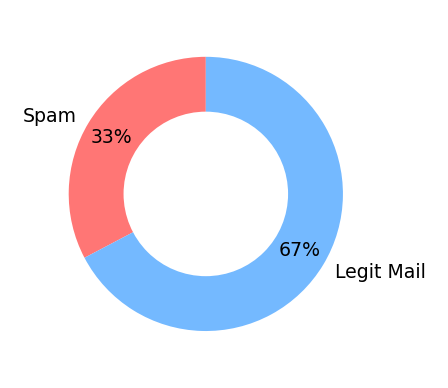

In [34]:
plt.figure(figsize = (2,2), dpi = 227)
custom_colors = ['#ff7675', '#74b9ff']

plt.pie(sizes, labels = category_names, textprops = {'fontsize':6}, startangle=90, autopct='%1.0f%%',
       colors = custom_colors, pctdistance = .8)

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

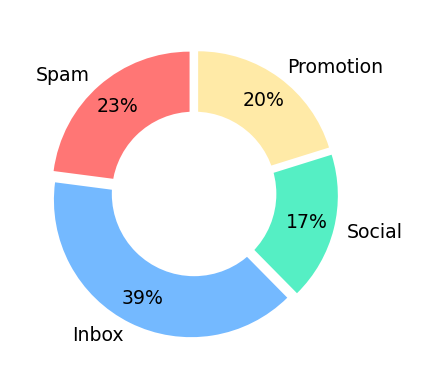

In [35]:
category_names = ['Spam', 'Inbox', 'Social', 'Promotion']
sizes = [25, 43, 19, 22]
custom_colors = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize = (2,2), dpi = 227)
plt.pie(sizes, labels = category_names, textprops = {'fontsize':6}, startangle=90, autopct='%1.0f%%',
       colors = custom_colors, pctdistance = .8, explode = offset)
#plt.title('Email Distribution', fontdict = {'fontsize': 8}, y = -0.1, loc = 'center')

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

## Natural Language Processing

### Text Preprocessing

In [36]:
msg = 'All work and no play makes Jack a dull boy. Must be hard being Jack right now.'
msg.lower()

'all work and no play makes jack a dull boy. must be hard being jack right now.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [37]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [38]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Tokenising

In [39]:
word_tokenize(msg.lower())

['all',
 'work',
 'and',
 'no',
 'play',
 'makes',
 'jack',
 'a',
 'dull',
 'boy',
 '.',
 'must',
 'be',
 'hard',
 'being',
 'jack',
 'right',
 'now',
 '.']

### Removing Stop Words

In [40]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
msg = 'All work and no play makes Jack a dull boy. Must be hard being Jack right now.'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if (word not in stop_words):
        filtered_words.append(word) 

filtered_words

['work',
 'play',
 'makes',
 'jack',
 'dull',
 'boy',
 '.',
 'must',
 'hard',
 'jack',
 'right',
 '.']

### Word Stems and Stemming

In [43]:
msg = 'All work and no play makes Jack a dull boy. Must be hard being Jack right now. \
Nobody expects the Spanish Inquisition.'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if (word not in stop_words):
        stem_word = snowball_stemmer.stem(word)
        filtered_words.append(stem_word) 

filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 '.',
 'must',
 'hard',
 'jack',
 'right',
 '.',
 'nobodi',
 'expect',
 'spanish',
 'inquisit',
 '.']

In [44]:
msg = 'All work and no play makes Jack a dull boy. Must be hard being Jack right now. \
Nobody expects the Spanish Inquisition.'
words = word_tokenize(msg.lower())

snowball_stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if (word not in stop_words):
        stem_word = snowball_stemmer.stem(word)
        filtered_words.append(stem_word) 

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', 'must', 'hard', 'jack', 'right', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '.']


### Removing Punctuation

In [45]:
msg = "All work and no play makes Jack a dull boy. Must be hard being Jack right now, don't you think?? \
Nobody expects the Spanish Inquisition."
words = word_tokenize(msg.lower())

snowball_stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if (word not in stop_words) & word.isalpha():
        stem_word = snowball_stemmer.stem(word)
        filtered_words.append(stem_word) 

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'must', 'hard', 'jack', 'right', 'think', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML Tags from Emails

In [46]:
data.at[0, 'MESSAGE']

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n<HTML><HEAD>\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\nype>\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n<BODY><!-- Inserted by Calypso -->\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\nules=3Dnone \nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n  <TBODY>\n  <TR>\n    <TD colSpan=3D3>\n      <HR color=3Dblack noShade SIZE=3D1>\n    </TD></TR></TD></TR>\n  <TR>\n    <TD colSpan=3D3>\n      <HR color=3Dblack noShade SIZE=3D1>\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n --><FONT \ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n0000 \nface=3D"Copperplate Gothic Bold" size=3D5 P

In [47]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')

print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=
 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=
/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% on 

In [48]:
print(soup.get_text())















<=
/TR>
Save up to 70% on Life Insurance.
Why Spend More Than You Have To?

Life Quote Savings










Ensurin=
g your 
      family's financial security is very important. Life Quote Savings ma=
kes 
      buying life insurance simple and affordable. We Provide FREE Access =
to The 
      Very Best Companies and The Lowest Rates.





Life Quote Savings is FAST, EAS=
Y and 
            SAVES you money! Let us help you get started with the best val=
ues in 
            the country on new coverage. You can SAVE hundreds or even tho=
usands 
            of dollars by requesting a FREE quote from Lifequote Savings. =
Our 
            service will take you less than 5 minutes to complete. Shop an=
d 
            compare. SAVE up to 70% on all types of Life insurance! 



Click Here For Your=
 
            Free Quote!

Protecting your family is the best investment you'll eve=
r 
          make!








If you are in receipt of this=
 email 
      in error and/or wish to be r

In [49]:
print('Testing the git commit feature')

Testing the git commit feature
